This notebook analyzes trading diversity (number of partner countries and types of commodities) , and build models to forecast crop export values by countries or globally

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator 
from sklearn.metrics import mean_squared_error

In [2]:
# Read in processed data
items_by_country = pd.read_csv('../data/processed/items_by_country.csv',index_col=0)
partners_by_country = pd.read_csv('../data/processed/partners_by_country.csv',index_col=0)
print(items_by_country.shape)
print(partners_by_country.shape)

(223049, 38)
(57838, 36)


In [3]:
items_by_country.head()

,Reporter Countries,Item,Element,Unit,Item Code,Y1986,Y1987,Y1988,Y1989,Y1990,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,NoneZero
0,Afghanistan,Almonds shelled,Export Quantity,tonnes,5313,0,0,0,0,0,...,4763,1308,2261,0,0,2714,2086,1778,2756,7
1,Afghanistan,Almonds shelled,Export Value,1000 US$,5313,0,0,0,0,0,...,35476,15894,20270,0,0,16454,12793,10934,19677,7
2,Afghanistan,Almonds shelled,Import Quantity,tonnes,1617,0,0,0,0,0,...,0,0,0,0,0,168,181,846,103,4
3,Afghanistan,Almonds shelled,Import Value,1000 US$,1617,0,0,0,0,0,...,0,0,0,0,0,1117,1377,4988,759,4
4,Afghanistan,"Almonds, with shell",Export Quantity,tonnes,3315,0,0,0,0,0,...,11066,779,1016,0,0,1856,1660,1545,875,7


In [4]:
partners_by_country.head()

,Reporter Countries,Partner Countries,Element,Unit,Y1986,Y1987,Y1988,Y1989,Y1990,Y1991,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
1,Afghanistan,Algeria,Export Value,1000 US$,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,27.0,1.0,24.0,5.0
3,Afghanistan,Angola,Export Value,1000 US$,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,Afghanistan,Argentina,Import Value,1000 US$,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,415.0,0.0,0.0,1163.0,159.0,1844.0,1829.0
7,Afghanistan,Armenia,Export Value,1000 US$,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,Afghanistan,Armenia,Import Value,1000 US$,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,48.0,0.0,0.0,282.0,246.0,0.0,67.0


## 1. Inspecting aggregated data and look for potential problems

### 1.1 Find countries with high trading diversity
In terms of number of (1)items and (2)partner countries, respectively

In [5]:
def count_unique(df, col_name, variable):
    '''count unique entries of the variable for col_name (e.g., list of reporter countries).
    Export and Import groups are counted separately'''
    counts = []
    for country in df[col_name].unique():
        count_export = len(df.loc[(df[col_name]== country) & (df['Element'].str.startswith('Export')), variable].unique())
        count_import = len(df.loc[(df[col_name]== country) & (df['Element'].str.startswith('Import')), variable].unique())
        counts.append([country,count_export,count_import])

    count_df = pd.DataFrame(counts, columns=['Countries','Export','Import'])
    
    return count_df

In [7]:
# Count unique Items exported/imported by a country
itemscount_by_country = count_unique(items_by_country,'Reporter Countries','Item')

In [ ]:
# Count unique Partners exported/imported with a country
partnerscount_by_country = count_unique(partners_by_country,'Reporter Countries','Partner Countries')

In [ ]:
# Show top 10 countries with most numbers of exporting items
itemscount_by_country = itemscount_by_country.sort_values(by='Export',ascending=False)
itemscount_by_country.head(10)

In [12]:
itemscount_by_country.describe()

,Export,Import
count,184.000000,184.000000
mean,267.788043,332.668478
std,93.621104,36.760841
min,11.000000,112.000000
25%,199.500000,323.000000
50%,306.500000,339.500000
75%,341.000000,356.000000
max,370.000000,376.000000


In [13]:
# Show top 10 countries with most numbers of exporting partners
partnerscount_by_country = partnerscount_by_country.sort_values(by='Export',ascending=False)
partnerscount_by_country.head(10)

,Countries,Export,Import
163,Thailand,244,227
155,South Africa,240,227
176,United States of America,238,234
7,Australia,238,218
119,New Zealand,237,225
102,Malaysia,236,217
24,Brazil,234,201
81,India,234,214
82,Indonesia,233,226
32,Canada,232,232


In [14]:
partnerscount_by_country.describe()

,Export,Import
count,184.000000,184.000000
mean,147.663043,166.673913
std,65.005049,44.632956
min,6.000000,34.000000
25%,100.000000,138.500000
50%,158.000000,173.500000
75%,202.000000,200.250000
max,244.000000,234.000000


 **Summary:** There is a big difference in items diversity among countries, as well as in number of trading partner countries

### Visualization 

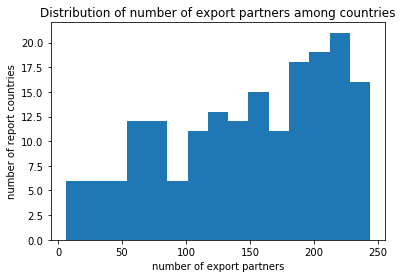

In [15]:
plt.hist(partnerscount_by_country['Export'],bins=15)
plt.title('Distribution of number of export partners among countries')
plt.ylabel('number of report countries')
plt.xlabel('number of export partners')
plt.show()

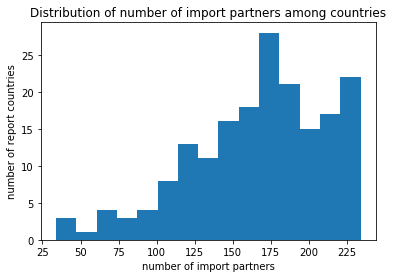

In [16]:
plt.hist(partnerscount_by_country['Import'],bins=15)
plt.title('Distribution of number of import partners among countries')
plt.ylabel('number of report countries')
plt.xlabel('number of import partners')
plt.show()

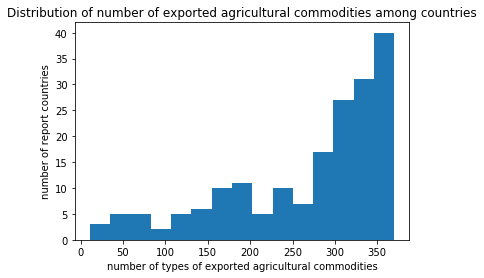

In [17]:
plt.hist(itemscount_by_country['Export'],bins=15)
plt.title('Distribution of number of exported agricultural commodities among countries')
plt.ylabel('number of report countries')
plt.xlabel('number of types of exported agricultural commodities')
plt.show()

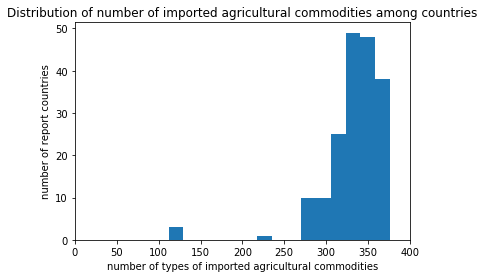

In [18]:
plt.hist(itemscount_by_country['Import'],bins=15)
plt.title('Distribution of number of imported agricultural commodities among countries')
plt.ylabel('number of report countries')
plt.xlabel('number of types of imported agricultural commodities')
plt.xlim(0,400)
plt.show()

In [288]:
# partnerscount_by_country.plot(x='Countries',kind='barh',fontsize= 8, figsize=(10,25))
# plt.xlabel('Number of trading partner countries')
# plt.show()

In [289]:
# itemscount_by_country.plot(x='Countries',kind='barh',fontsize= 8, figsize=(10,25))
# plt.xlabel('Number of types of agricultural commodities traded')
# plt.show()

### 1.2 Rank items and countries by total values traded

#### 1. Find the top five crops in exporting values summed between 1986 and 2017

In [19]:
items_total = items_by_country.drop('Item Code',axis=1).groupby(['Item','Element']).sum().reset_index()

In [20]:
items_total.shape

(1670, 34)

In [21]:
items_total.head()

,Item,Element,Y1986,Y1987,Y1988,Y1989,Y1990,Y1991,Y1992,Y1993,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,Alfalfa meal and pellets,Export Quantity,780721.0,674729.0,1281274.0,945720.0,898612.0,1115589.0,1320243.0,1505566.0,...,1141409.0,917478.0,1301256.0,1352509.0,1629006.0,1230975.0,1230904.0,1257591.0,1250588.0,1185340.0
1,Alfalfa meal and pellets,Export Value,85939.0,76271.0,162381.0,124439.0,124086.0,137893.0,158757.0,170117.0,...,283189.0,199680.0,325348.0,338355.0,454384.0,344310.0,335681.0,303085.0,308622.0,316512.0
2,Alfalfa meal and pellets,Import Quantity,747809.0,625348.0,922591.0,878304.0,861054.0,1026067.0,1129702.0,1316800.0,...,1045324.0,722642.0,814707.0,807915.0,862389.0,762030.0,1840831.0,1999653.0,1979886.0,928731.0
3,Alfalfa meal and pellets,Import Value,91413.0,77803.0,119357.0,120259.0,126511.0,134983.0,153154.0,159708.0,...,325525.0,186694.0,192576.0,230616.0,261140.0,256209.0,651632.0,590255.0,522431.0,265593.0
4,Almonds shelled,Export Quantity,100123.0,89685.0,117115.0,125555.0,136050.0,114860.0,152612.0,164122.0,...,469820.0,545526.0,558735.0,624217.0,651907.0,680869.0,691473.0,661657.0,755735.0,777981.0


In [22]:
years = items_total.columns[2:]

In [23]:
years

Index(['Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991', 'Y1992', 'Y1993',
       'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999', 'Y2000', 'Y2001',
       'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007', 'Y2008', 'Y2009',
       'Y2010', 'Y2011', 'Y2012', 'Y2013', 'Y2014', 'Y2015', 'Y2016', 'Y2017'],
      dtype='object')

In [24]:
items_total['Sum'] = items_total[years].sum(axis=1)

We shall focus on export quantity and value of crops.

In [25]:
items_total_exportQ = items_total.loc[items_total['Element']=='Export Quantity',:]
items_total_exportV = items_total.loc[items_total['Element']=='Export Value',:]

In [26]:
# Check the top items in export value and select crops
items_total_exportV = items_total_exportV.sort_values(by='Sum',ascending=False)
print(items_total_exportV['Item'][:20])
print(items_total_exportV.shape)

595                              Food prep nes
1635                                     Wheat
1431                                  Soybeans
431                            Crude materials
1647                                      Wine
873                                      Maize
99              Beverages, distilled alcoholic
931       Meat, cattle, boneless (beef & veal)
291                     Cheese, whole cow milk
331                                 Cigarettes
1155                                 Oil, palm
223                             Cake, soybeans
323                     Chocolate products nes
1227                                    Pastry
935                              Meat, chicken
379                              Coffee, green
1347    Rice - total  (Rice milled equivalent)
979                                 Meat, pork
403                                Cotton lint
1371                        Rubber natural dry
Name: Item, dtype: object
(417, 35)


The top five exported crops between 1986 and 2017 (in 1000 US$, not counting processed products) are:   
Wheat, Soybeans, Maize, Coffee, and Cotton

In [305]:
# Check the top items in export quantity and select crops
items_total_exportQ = items_total_exportQ.sort_values(by='Sum',ascending=False)
print(items_total_exportQ['Item'][:20])
print(items_total_exportQ.shape)

430                            Crude materials
1634                                     Wheat
12                            Animals live nes
872                                      Maize
1430                                  Soybeans
222                             Cake, soybeans
66                                      Barley
1270                                      Pigs
1346    Rice - total  (Rice milled equivalent)
1154                                 Oil, palm
1454                     Sugar Raw Centrifugal
1626                            Waters,ice etc
1358                              Rice, milled
1480                             Sugar refined
62                                     Bananas
1386                                     Sheep
1342                                  Rapeseed
106                   Beverages, non alcoholic
586                               Flour, wheat
266                                     Cattle
Name: Item, dtype: object
(416, 35)


Top top five exported crops between 1986 and 2017 (tonnes) are:   
Wheat, Maize, Soybeans, Barley and Rice - total  (Rice milled equivalent)

#### 2. Find the top five countries in terms of total exporting values during the past three years

In [27]:
country_total = partners_by_country.groupby(['Reporter Countries','Element']).sum().reset_index()

In [28]:
country_total['3y_mean'] = country_total[['Y2015','Y2016','Y2017']].mean(axis=1)

In [29]:
country_total = country_total.sort_values(by='3y_mean', ascending=False)
country_total_exportV = country_total.loc[country_total['Element']=='Export Value',:]

In [30]:
# Find top countries in exporting values of agricultural goods
print(country_total_exportV['Reporter Countries'][:20])

352    United States of America
232                 Netherlands
138                     Germany
48                       Brazil
126                      France
76              China, mainland
312                       Spain
64                       Canada
172                       Italy
30                      Belgium
326                    Thailand
164                   Indonesia
8                     Argentina
14                    Australia
162                       India
218                      Mexico
348              United Kingdom
264                      Poland
204                    Malaysia
238                 New Zealand
Name: Reporter Countries, dtype: object


The top 5 countries in 3-year average (2015-2017) exporting values of agricultural commodities are:  
USA, Netherlands, Germany, Brazil and France

In [31]:
country_total_exportV.shape

(184, 35)

## 2. Build simple linear regression models on time series data for the top crops and countries

### 2.1 Models for wheat export 

#### 1) Find countries that have more complete data set >50% (16 years) non-zero trading data for wheat

In [32]:
items_by_country.head()

,Reporter Countries,Item,Element,Unit,Item Code,Y1986,Y1987,Y1988,Y1989,Y1990,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,Afghanistan,Almonds shelled,Export Quantity,tonnes,5313,0.0,0.0,0.0,0.0,0.0,...,0.0,4763.0,1308.0,2261.0,0.0,0.0,2714.0,2086.0,1778.0,2756.0
1,Afghanistan,Almonds shelled,Export Value,1000 US$,5313,0.0,0.0,0.0,0.0,0.0,...,0.0,35476.0,15894.0,20270.0,0.0,0.0,16454.0,12793.0,10934.0,19677.0
2,Afghanistan,Almonds shelled,Import Quantity,tonnes,1617,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,168.0,181.0,846.0,103.0
3,Afghanistan,Almonds shelled,Import Value,1000 US$,1617,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1117.0,1377.0,4988.0,759.0
4,Afghanistan,"Almonds, with shell",Export Quantity,tonnes,3315,0.0,0.0,0.0,0.0,0.0,...,0.0,11066.0,779.0,1016.0,0.0,0.0,1856.0,1660.0,1545.0,875.0


In [33]:
# Calculate number of years with non-zero trading data
items_by_country['NoneZero'] = 32 - (items_by_country[years] == 0).sum(axis=1)

In [303]:
items_by_country.head()

,Reporter Countries,Item,Element,Unit,Item Code,Y1986,Y1987,Y1988,Y1989,Y1990,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,NoneZero
0,Afghanistan,Almonds shelled,Export Quantity,tonnes,5313,0.0,0.0,0.0,0.0,0.0,...,4763.0,1308.0,2261.0,0.0,0.0,2714.0,2086.0,1778.0,2756.0,7
1,Afghanistan,Almonds shelled,Export Value,1000 US$,5313,0.0,0.0,0.0,0.0,0.0,...,35476.0,15894.0,20270.0,0.0,0.0,16454.0,12793.0,10934.0,19677.0,7
2,Afghanistan,Almonds shelled,Import Quantity,tonnes,1617,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,168.0,181.0,846.0,103.0,4
3,Afghanistan,Almonds shelled,Import Value,1000 US$,1617,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1117.0,1377.0,4988.0,759.0,4
4,Afghanistan,"Almonds, with shell",Export Quantity,tonnes,3315,0.0,0.0,0.0,0.0,0.0,...,11066.0,779.0,1016.0,0.0,0.0,1856.0,1660.0,1545.0,875.0,7


In [304]:
items_by_country.to_csv('../data/processed/items_by_country.csv')

#### 2) data preprocessing 

In [293]:
# Select wheat export quantity
# Select countries with >= 16 years of wheat export quantity data
wheat_export_q = items_by_country.loc[(items_by_country['Item']=='Wheat')&(items_by_country['Element']=='Export Quantity'),:]
wheat_export_q_50 = wheat_export_q.loc[wheat_export_q['NoneZero']>=16,:]
print(wheat_export_q_50.shape)
wheat_export_q_50.head()

# 76 countries selected

(76, 38)


,Reporter Countries,Item,Element,Unit,Item Code,Y1986,Y1987,Y1988,Y1989,Y1990,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,NoneZero
5829,Argentina,Wheat,Export Quantity,tonnes,1830,3797839.0,4192092.0,3642579.0,4322854.0,5836659.0,...,5118007.0,4038997.0,8411139.0,11461361.0,2388933.0,1852412.0,4311207.0,10266237.0,13099133.0,32
9408,Australia,Wheat,Export Quantity,tonnes,1770,15833410.0,14718837.0,8087692.0,8508106.0,11520813.0,...,14996065.0,15888041.0,17657181.0,23535864.0,18001620.0,18282774.0,17053209.0,16148015.0,22357824.0,32
10904,Austria,Wheat,Export Quantity,tonnes,1185,280176.0,476207.0,799823.0,425824.0,423985.0,...,544203.0,710046.0,619754.0,587835.0,543329.0,880505.0,825290.0,741324.0,730976.0,32
17127,Barbados,Wheat,Export Quantity,tonnes,135,3.0,1.0,0.0,0.0,1500.0,...,1.0,1.0,21.0,39.0,199.0,110.0,0.0,0.0,0.0,22
18464,Belarus,Wheat,Export Quantity,tonnes,135,0.0,0.0,0.0,0.0,0.0,...,45.0,4836.0,377.0,208.0,303.0,388.0,35144.0,91658.0,378.0,19


In [34]:
# Select countries with >= 16 years of wheat export value data
wheat_export_value = items_by_country.loc[(items_by_country['Item']=='Wheat')&(items_by_country['Element']=='Export Value'),:]
wheat_export_value_50 = wheat_export_value.loc[wheat_export_value['NoneZero']>=16,:]
print(wheat_export_value_50.shape)
wheat_export_value_50.head()

# 75 countries were selected

(75, 38)


,Reporter Countries,Item,Element,Unit,Item Code,Y1986,Y1987,Y1988,Y1989,Y1990,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,NoneZero
5830,Argentina,Wheat,Export Value,1000 US$,1830,374614.0,351003.0,355226.0,657540.0,870936.0,...,1001973.0,901824.0,2508660.0,2937806.0,725395.0,603675.0,1032847.0,1867747.0,2361856.0,32
9409,Australia,Wheat,Export Value,1000 US$,1770,1837595.0,1369375.0,1066732.0,1382707.0,1664054.0,...,3254699.0,3845506.0,5709040.0,6765445.0,5895653.0,5343407.0,4371505.0,3621345.0,4650327.0,32
10905,Austria,Wheat,Export Value,1000 US$,1185,32330.0,40372.0,78313.0,79656.0,53462.0,...,144764.0,202892.0,248774.0,205418.0,205738.0,290428.0,236625.0,192220.0,195575.0,32
17128,Barbados,Wheat,Export Value,1000 US$,135,1.0,0.0,0.0,0.0,291.0,...,1.0,1.0,18.0,15.0,76.0,37.0,0.0,0.0,1.0,19
18465,Belarus,Wheat,Export Value,1000 US$,135,0.0,0.0,0.0,0.0,0.0,...,24.0,746.0,211.0,194.0,240.0,280.0,4934.0,11986.0,180.0,19


In [294]:
print(wheat_export_q_50.sort_values(by='Y2017',ascending=False)['Reporter Countries'][:10])

169075          Russian Federation
214507    United States of America
9408                     Australia
40137                       Canada
208673                     Ukraine
77137                       France
5829                     Argentina
83515                      Germany
167643                     Romania
110261                  Kazakhstan
Name: Reporter Countries, dtype: object


In [295]:
# Reshape data from wide to long by years 
wheat_long = wheat_export_q_50.melt(['Reporter Countries'],years,'year','value')

In [296]:
wheat_long.head()

,Reporter Countries,year,value
0,Argentina,Y1986,3797839.0
1,Australia,Y1986,15833410.0
2,Austria,Y1986,280176.0
3,Barbados,Y1986,3.0
4,Belarus,Y1986,0.0


In [297]:
# Convert df to time series
wheat_long['year'] = wheat_long['year'].map(lambda x: x.lstrip('Y')) # strip Y from year names for easy converting to ts
wheat_long.year = pd.to_datetime(wheat_long.year)

In [298]:
wheat_long.head()

,Reporter Countries,year,value
0,Argentina,1986-01-01,3797839.0
1,Australia,1986-01-01,15833410.0
2,Austria,1986-01-01,280176.0
3,Barbados,1986-01-01,3.0
4,Belarus,1986-01-01,0.0


In [299]:
# Reshape data from long to wide, by countries
wheat_wide = wheat_long.pivot(index='year',columns='Reporter Countries',values='value')

In [300]:
wheat_wide.head()

Reporter Countries,Argentina,Australia,Austria,Barbados,Belarus,Belgium,Brazil,Bulgaria,Canada,Chile,...,Turkey,Uganda,Ukraine,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Yemen,Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
1986-01-01,3797839.0,15833410.0,280176.0,3.0,0.0,0.0,0.0,299820.0,15878633.0,21.0,...,16214.0,0.0,0.0,3249642.0,0.0,24437978.0,0.0,0.0,0.0,1.0
1987-01-01,4192092.0,14718837.0,476207.0,1.0,0.0,0.0,0.0,271812.0,21920644.0,23749.0,...,296556.0,0.0,0.0,3637242.0,0.0,30435797.0,0.0,0.0,0.0,0.0
1988-01-01,3642579.0,8087692.0,799823.0,0.0,0.0,0.0,0.0,390769.0,19986518.0,83.0,...,1739493.0,0.0,0.0,1694316.0,0.0,40275216.0,0.0,0.0,0.0,0.0
1989-01-01,4322854.0,8508106.0,425824.0,0.0,0.0,0.0,0.0,0.0,11202955.0,98.0,...,539525.0,0.0,0.0,2907822.0,0.0,36519094.0,165126.0,0.0,0.0,0.0
1990-01-01,5836659.0,11520813.0,423985.0,1500.0,0.0,0.0,0.0,0.0,17849160.0,1027.0,...,24972.0,0.0,0.0,4400675.0,0.0,27389380.0,163867.0,0.0,0.0,0.0


In [301]:
wheat_wide.to_csv('../data/processed/wheat_export_quantity_50.csv')

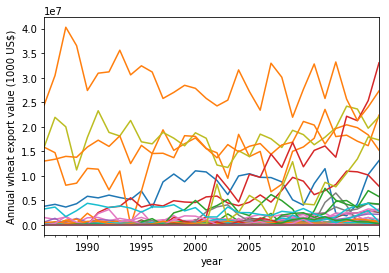

In [302]:
# Visualize data by countries 
# This data now contains zeros (potential missing values)
wheat_wide.plot(legend=False)
#plt.title('Annual wheat export value by countries (1986 - 2017)')
plt.ylabel('Annual wheat export quantity (tonnes)')
plt.show()

In [211]:
# # Interpolate outliers
wheat_wide = wheat_wide.replace(0,np.nan) # Replace zeros with nans

# # Interpolate use linear method
wheat_wide_interp = wheat_wide.interpolate('linear')
wheat_wide_interp.head()

After linear interpolation, there are still many Nans because for some countries the first year's data are zeros.

#### 3) Linear regression model with raw time series data (baseline model)

In [46]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score

#### Below is a test approach which we did not end up pursue further. Here countries were used as samples

In [47]:
# Randomly select a country as y, the rest countries as X 
# Use countries in X to predict the wheat export of country in y at a timestamp
country = wheat_wide.sample(1,axis=1, random_state=1)
country.head()

Reporter Countries,Finland
year,
1986-01-01,5019.0
1987-01-01,10491.0
1988-01-01,438.0
1989-01-01,8460.0
1990-01-01,3401.0


In [279]:
X = wheat_wide.drop(country, axis=1).values
y = country.values
print(X.shape)
print(y.shape)

(32, 74)
(32, 1)


In [49]:
# Cross validation
cv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(Ridge(), X, y, cv=cv)
print(scores)

[  -82.41073431 -1475.51969324   -13.17808944    -4.20519267
    -2.61037821]


### Problem: too few data points per sample (country)

In [280]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    train_size=.6, shuffle=False, random_state=1)

model = Ridge()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
score = r2_score(y_test,predictions)
print(score)

-4.159187817069363


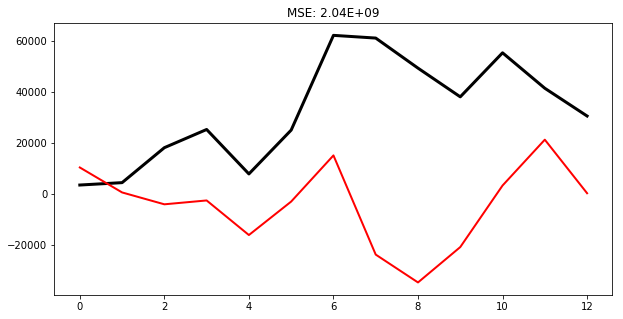

In [283]:
# Visualize prediction results
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_test, color='k', lw=3)
ax.plot(predictions, color='r', lw=2)
plt.title('MSE: %.2E'% mean_squared_error(predictions, y_test))
plt.show()

Summary: Not surprisingly, using raw data the baseline model performance is not satisfying.  
Next we consider using ARIMA model for forecasting export of a single item for a specific country.

### ARIMA model

In [92]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

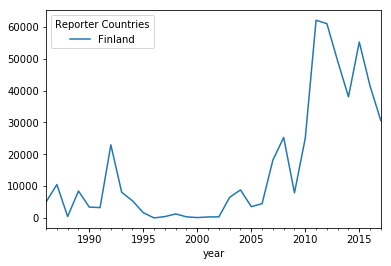

In [54]:
country.plot()

In [127]:
results = adfuller(country['Finland'].dropna())
print(results[1])
# Passed Dickey-Fuller test and the series is actually stationary

0.7183493610964914


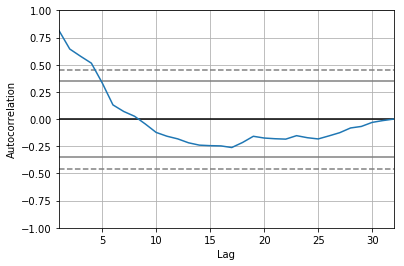

In [186]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(country['Finland'])

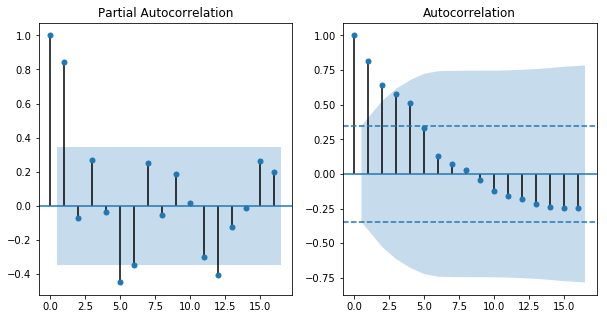

In [113]:
# Check ACF and PACF 
n = len(country['Finland'])
fig, axs = plt.subplots(1,2, figsize=(10,5))

plot_pacf(country['Finland'], ax= axs[0])
plt.axhline(y=-1.96/np.sqrt(n),linestyle='--')
plt.axhline(y=1.96/np.sqrt(n),linestyle='--')

plot_acf(country['Finland'], ax= axs[1])
plt.show()


According to the partial autocorrelation function(PACF), data seems to be a AR1 process

/Users/Sabrina/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'MSE: 9.25E+07')

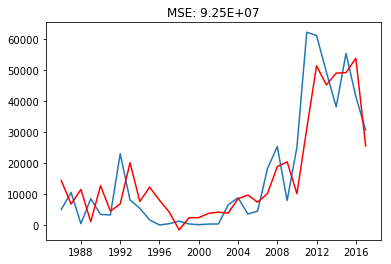

In [290]:
# Build a AR model
data = country['Finland']
model = ARIMA(data, order = (6,0,0))
ar_1 = model.fit()
plt.plot(data)
plt.plot(ar_1.fittedvalues, color='red')
plt.title('MSE: %.2E'% mean_squared_error(ar_1.fittedvalues,data))

/Users/Sabrina/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'MSE: 1.41E+08')

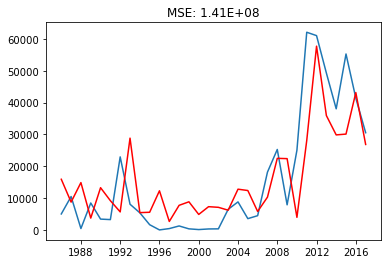

In [285]:
# Build a MA model
data = country['Finland']
model = ARIMA(data, order = (0,0,2))
ma_1 = model.fit()
plt.plot(data)
plt.plot(ma_1.fittedvalues, color='red')
plt.title('MSE: %.2E'% mean_squared_error(ma_1.fittedvalues,data))

AR model performed better and MA model in this case, after trying out a few parameters for each model.  
Let's try forecast a few years with AR model.

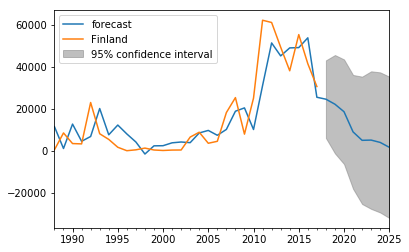

In [205]:
ar_1.plot_predict(start='1988', end = '2025')
plt.show()

The prediction looks reasonable. However, this model may be improved with more parameter tuning.  
Next: we can create an analysis pipeline which can conduct a gridsearch to estimate best combinations of ARIMA parameters (p,d,q) for a specific item and country.

#### 4) Feature engineering          

We shall first calculate basic features with rolling windows, such as mean, max, min, std.  
Then we will use package tsfresh to automatically generate and screen hundreds of features.

In [309]:
countries.head()

Reporter Countries,Argentina,Australia,Austria,Barbados,Belarus,Belgium,Brazil,Bulgaria,Canada,Chile,...,Turkey,Uganda,Ukraine,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Yemen,Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
1986-01-01,374614.0,1837595.0,32330.0,1.0,0.0,0.0,0.0,41970.0,2030112.0,10.0,...,1836.0,0.0,0.0,539790.0,0.0,2996911.0,0.0,0.0,0.0,0.0
1987-01-01,351003.0,1369375.0,40372.0,0.0,0.0,0.0,0.0,0.0,2409105.0,2421.0,...,28298.0,0.0,0.0,436869.0,0.0,3024544.0,0.0,0.0,0.0,8.0
1988-01-01,355226.0,1066732.0,78313.0,0.0,0.0,0.0,0.0,63101.0,3596008.0,18.0,...,173522.0,0.0,0.0,246768.0,0.0,4858495.0,0.0,0.0,0.0,0.0
1989-01-01,657540.0,1382707.0,79656.0,0.0,0.0,0.0,0.0,0.0,2173767.0,25.0,...,67682.0,0.0,0.0,462332.0,0.0,5905543.0,24194.0,0.0,0.0,0.0
1990-01-01,870936.0,1664054.0,53462.0,291.0,0.0,0.0,0.0,0.0,2847737.0,356.0,...,4382.0,0.0,0.0,746334.0,0.0,3866314.0,22861.0,0.0,0.0,0.0


In [316]:
# Take Argentina as an example
features = countries['Argentina'].rolling(5).aggregate([np.mean,np.max,np.min,np.std])
argentina = countries['Argentina']

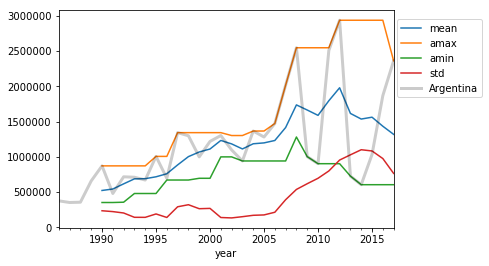

In [318]:
ax = features.plot()
argentina.plot(ax=ax, color='k',alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

In [346]:
# Calculate for all countries, store in separate dataframes
means = pd.DataFrame()
maxs = pd.DataFrame()
mins = pd.DataFrame()
stds = pd.DataFrame()

for country in wheat_wide.columns:
    
    means[country] = wheat_wide[country].rolling(5).mean()
    maxs[country] = wheat_wide[country].rolling(5).max()
    mins[country] = wheat_wide[country].rolling(5).min()
    stds[country] = wheat_wide[country].rolling(5).std()


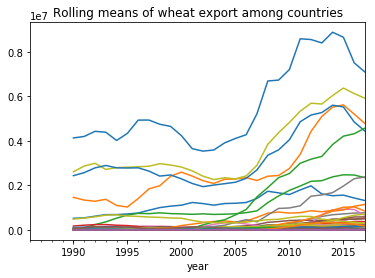

In [370]:
#fig,axs = plt.subplots(1,2,figsize=(15,5))
means.plot(legend=False)
#maxs.plot(ax=axs[1],legend=False)
#mins.plot(ax=axs[0])
#stds.plot(ax=axs[1],legend=False)
plt.title('Rolling means of wheat export among countries')
plt.show()


Summary: from comparing plots of different features, rolling means smooth out the data best and reduced noise. we shall use rolling means instead of raw data for further analysis

### 2.2 Models for top five crops, treating crops as features 
Note: this is another approach we tried but did not pursue further
#### 1) Data preprocessing

In [444]:
# extract crops and 
# rank countries by non-zero years, slicing the top half countries with less non-zero data
# Reshape dataframe to treat crops as features and countries as samples
crops = ['Wheat', 'Soybeans', 'Maize', 'Coffee, green', 'Cotton lint']
        
crop_export_value = items_by_country.loc[(items_by_country['Item'].isin(crops))&(items_by_country['Element']=='Export Value'),:]

crop_long = crop_export_value.melt(['Reporter Countries','Item'], years, 'year', 'value')
crop_long['year'] = crop_long['year'].map(lambda x: x.lstrip('Y'))

In [445]:
crop_long.head()

,Reporter Countries,Item,year,value
0,Afghanistan,Cotton lint,1986,0.0
1,Afghanistan,Maize,1986,0.0
2,Afghanistan,Soybeans,1986,0.0
3,Afghanistan,Wheat,1986,0.0
4,Albania,"Coffee, green",1986,0.0


In [459]:
# Reshape df so that crops are the columns
crop_wide = crop_long.groupby(['Reporter Countries', 'year', 'Item'])['value'].sum().unstack('Item')
crop_wide = crop_wide.reset_index()
crop_wide.year = pd.to_datetime(crop_wide.year)

In [505]:
# Count Nans of all crops for each country,select countries without NaNs
# A lot of the time when a country has NaNs, the crop is not exported so the whole time series is NaN,
# thus not ideal to use imputations to deal with NaN.
# We will just use data of countries that exports all five crops
crop_wide['Nans'] = crop_wide.isna().sum(axis=1)
crop_wide.head()
sums = crop_wide.groupby(["Reporter Countries"]).sum().sort_values(by='Nans',ascending=True).reset_index()
selected_countries = sums.loc[sums['Nans'] == 0,'Reporter Countries'].tolist()

In [516]:
crop_selected_countries = crop_wide.loc[crop_wide["Reporter Countries"].isin(selected_countries),:]
crop_selected_countries.head()

Item,Reporter Countries,year,"Coffee, green",Cotton lint,Maize,Soybeans,Wheat,Nans
32,Albania,1986-01-01,0.0,0.0,0.0,0.0,0.0,0
33,Albania,1987-01-01,0.0,0.0,0.0,0.0,0.0,0
34,Albania,1988-01-01,0.0,0.0,0.0,0.0,0.0,0
35,Albania,1989-01-01,0.0,0.0,0.0,0.0,0.0,0
36,Albania,1990-01-01,0.0,0.0,0.0,0.0,0.0,0


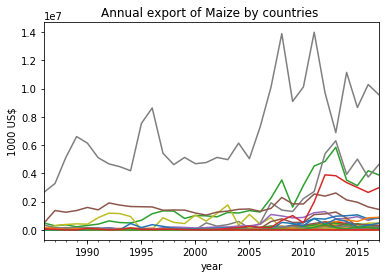

In [529]:
# Visualize Maize export 
fig, ax = plt.subplots()

for key, grp in crop_selected_countries.groupby(['Reporter Countries']):
    ax = grp.plot(ax=ax, kind='line', x='year', y='Maize',label=key, legend=False)
plt.title('Annual export of Maize by countries ')
plt.ylabel('1000 US$')
plt.show()

#### 2) linear models using 4 crop export as features and countries as samples, to predict wheat export

In [534]:
crop_selected_countries[crops].head()

Item,Wheat,Soybeans,Maize,"Coffee, green",Cotton lint
32,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,0.0,0.0
35,0.0,0.0,0.0,0.0,0.0
36,0.0,0.0,0.0,0.0,0.0


In [535]:
X = crop_selected_countries[crops].drop(['Wheat'],axis=1).values
y = crop_selected_countries['Wheat'].values
print(X.shape, y.shape)

(4288, 4) (4288,)


In [536]:
# Cross validation
cv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(Ridge(), X, y, cv=cv)
print(scores)

[-0.15144885 -0.45351119 -1.48027963  0.19133732  0.81098473]


In [537]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    train_size=.8, shuffle=False, random_state=1)

model = Ridge()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
score = r2_score(y_test,predictions)
print(score)

0.800916580865393


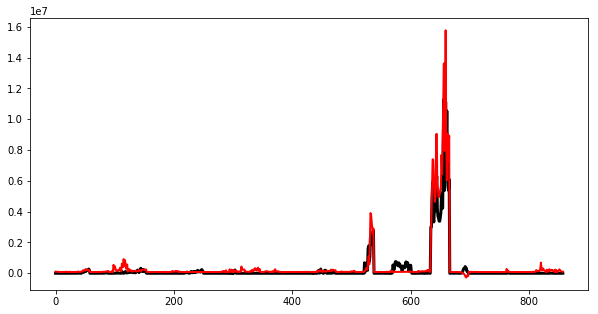

In [538]:
# Visualize prediction results
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_test, color='k', lw=3)
ax.plot(predictions, color='r', lw=2)
plt.show()

#### Summary: use four crops' export time series data, the prediction of wheat export is relatively accurate (R^2 = 0.8)

It is an interesting approach, but the result is less straightforward and less interpretable, as the prediction is based on a combination of four other crops. Given the small datasize (annual data), it is hard to select the most predictable items among all commodities for modeling.

Therefore, in next notebooks, we shall focus of ARIMA modeling for single item and country.